In [1]:
#import modules
import pandas as pd
import numpy as np
import Bio
from Bio import Seq
from Bio import SeqIO
import torch
import matplotlib.pyplot as plt
import sys
from torch.utils.data import TensorDataset, DataLoader
import functions
import random
import pickle

In [2]:
#define data file paths for running on digs
thermo_path_digs = '/home/achazing/other/classes/data_science_class/ThermoDrift/data/uniprot-thermophilus.fasta'
psychro_path_digs = '/home/achazing/other/classes/data_science_class/ThermoDrift/data/uniprot-psychrophilus.fasta'
meso_path_digs = '/home/achazing/other/classes/data_science_class/ThermoDrift/data/uniprot-mesophilus.fasta'

In [18]:
#define data file paths for running locally/testing
thermo_path_local = '../../../data_sets/thermal_proteins/uniprot-thermophilus.fasta'
psychro_path_local = '../../../data_sets/thermal_proteins/uniprot-psychrophilus.fasta'
meso_path_local = '../../../data_sets/thermal_proteins/uniprot-mesophilus.fasta'

In [19]:
#run the fasta_to_classified_df function
df_thermo = functions.fasta_to_classified_df(thermo_path_digs,protein_class=0,sample=True)
df_meso = functions.fasta_to_classified_df(meso_path_digs,protein_class=1)
df_psychro = functions.fasta_to_classified_df(psychro_path_digs,protein_class=2)


20718
19386
23618


In [20]:
#filter the 

In [21]:
#run the combine_dfs function
list_dfs = [df_thermo,df_meso,df_psychro]
df_combine = functions.combine_dfs(list_dfs)

In [22]:
set(df_combine['class'])

{0, 1, 2}

In [23]:
df_combine.head()

,protein,sequence,class
0,tr|R5ZGD1|R5ZGD1_9STRE,MSIFASAFTPISVSSAKENIASAEKFILFIGRPSCPYCQLFEPKLS...,0
1,tr|A0A0K6IUX4|A0A0K6IUX4_9PROT,MKTAQRLRRQRRFAWRRLAGVGTVAAVGALFSWPAGLGLLALGLGW...,0
2,tr|A0A4V1A2T9|A0A4V1A2T9_9BACL,MAKKIVLCCEECGSRNYTYPEKENTTRLMLKKYCPHCKRHTLHKQTR,0
3,tr|A0A2X3UH48|A0A2X3UH48_STRTR,MKVTVYLGANMGDNPSFKEATIALGRWIAKNSLILVYGGSKMGLMG...,0
4,tr|A0A4P6UQX6|A0A4P6UQX6_9BACL,MIEIEKPRIETVEISEDSTYGKFVVEPLERGYGTTLGNSLRRILLS...,0


In [24]:
#create lists of sequences and classes
seq_list = df_combine['sequence'].tolist()
class_list = df_combine['class'].tolist()

length_list = [len(i) for i in seq_list]
df_combine['length'] = length_list

In [25]:
#Create a list of tuples to load examples into ESM1b
tuple_data = [(class_list[i],seq_list[i]) for i in range(len(seq_list))]
tuple_data[:3]

[(0,
  'MSIFASAFTPISVSSAKENIASAEKFILFIGRPSCPYCQLFEPKLSNVARKSEFNIFYINSENTDELGEIQALRKRYGIATVPALFVSEKGAAKVVCDSSLSEEDILDFIS'),
 (0,
  'MKTAQRLRRQRRFAWRRLAGVGTVAAVGALFSWPAGLGLLALGLGWAWWCVEREFAEVLGEALTGAPHEDLSPRARLVLEPLRAQERVWRRRVEAARRDRERLIAAWDRLPVGVVWLAADGTIRRLNRRAEDLLQLQRRLHGGQPLALFLPEPRWLERIRASGEAGFTGEVPRRGETLHCRLQWVPLEEGEALLLVEDRTEAMRLERMRRDFVANVSHELRTPLTIVRGYVETALDAPTPLPPPLAGYLEQVHAQAVRMQRLVEDLLTLAQLEGTQPPPAKWVDVGELLETAAAQARGVAPEGLTVEVDFPPQPGAILGVRTELESALGNLALNAVRYTPAPGRVVIGARAAENGEGELFVRDTGIGIAPEHLPRLTERFYRVDRARSRDRGGTGLGLAIVNHVAQRHEARLFIDSAPGKGSEFRLRFPSGRWREGEAVK'),
 (0, 'MAKKIVLCCEECGSRNYTYPEKENTTRLMLKKYCPHCKRHTLHKQTR')]

In [26]:
#create a list of tuples that have been filtered on size to load examples into ESM1b
tuple_data_filtered = []
for i in range(len(seq_list)):
    if len(seq_list[i]) >= 75 and len(seq_list[i]) <= 500:
        tuple_data_filtered.append((class_list[i],seq_list[i]))

In [27]:
set(tuple_data_filtered[i][0] for i in range(len(tuple_data_filtered)))

{0, 1, 2}

In [28]:
len_thermo = []
len_psychro = []
len_meso = []
for i in range(len(tuple_data_filtered)):
    if tuple_data_filtered[i][0] == 0:
        len_thermo.append(len(tuple_data_filtered[i][1]))
    elif tuple_data_filtered[i][0] == 1:
        len_meso.append(len(tuple_data_filtered[i][1]))
    elif tuple_data_filtered[i][0] == 2:
        len_psychro.append(len(tuple_data_filtered[i][1]))

In [29]:
print('len_thermo is ',len(len_thermo),'len_meso is ',len(len_meso),'len_psychro is ',len(len_psychro))

len_thermo is  16216 len_meso is  15780 len_psychro is  19095


Text(0.5, 0, '')

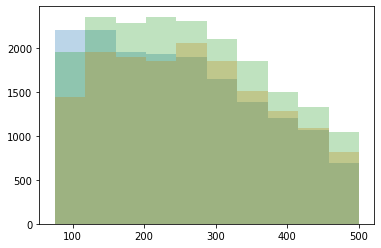

In [30]:
plt.hist(len_thermo,label='len_thermo',alpha=0.3)
plt.hist(len_meso,label='len_thermo',alpha=0.3)
plt.hist(len_psychro,label='len_thermo',alpha=0.3)
plt.xlabel('')

In [31]:
#create length filtered tuple lists for each class
tuples_thermo = []
tuples_psychro = []
tuples_meso = []
for i in range(len(tuple_data_filtered)):
    if tuple_data_filtered[i][0] == 0:
        tuples_thermo.append(tuple_data_filtered[i])
    elif tuple_data_filtered[i][0] == 1:
        tuples_meso.append(tuple_data_filtered[i])
    elif tuple_data_filtered[i][0] == 2:
        tuples_psychro.append(tuple_data_filtered[i])

In [32]:
#shuffle the tuple lists to randomize order of examples

random.shuffle(tuples_thermo)
random.shuffle(tuples_meso)
random.shuffle(tuples_psychro)
tuples_thermo[:3]

[(0,
  'MTWDYFVALSDNPGEQETLARPEGLSGGFVDEVSVRFFQGDKESARRRYMEGANGDIRLPEIISENAPDFSSLPSSTWVALQVDFELLTPWYSKDDRVFHLLDNPVCKDRVFGVPFMAASSWKGMLRWAFRMCTKKLVGPEQETDEGKLKQAKAWEWHLFGNEKGEGEEFSRGALVFYPTWFNKIGFEVINPHSRERRAGTQPIYYEVVPPGAQGTLSLLYAPWPGMKPAVKAEEVLPKLFEAVEALLTTYGISAKRTVGWGTAKILKWRAFHKTEGTVEKDNRADLEREVQAWLSAGGTP'),
 (0,
  'MNKEHGRSPSFLEALIGLILIITVIVGTIRIELVLETPLVLGSVTAALFGLYLGYSWDSIQEGMIDGIRNGLIACLILIIVGMVVGTWILGGTIQTLIYYGLQFLSPTIFLPATFLLCAITSLFIGSSFGTIATMGLVLLGVGGGLGIPAGMTAGAIASGAIFGDKMSPLSDSTNLASAMTGANLFDHIGSMLWVTAPATIISLILYTIIGLGQSGGAVDLQEVNTILETLQSNFNITLLTLIPPVLVLILSIKKVPALATLMISFFAGSLIAVITQGASLSSIITVSASGYEASTGVEFVDELLTHGGINMMMGTVAMILAGTAMGGILERCGVLKVLLNGMLQYVKTPRGLILSTLASAYIMLLASAEMMVSIIVPGRTFQPAYNDMNVELSVLSRTLESAATLGCIALPWGVASVYLQGVLDVGFEFIPYTFISFLAPVIVIIYAVTNTGFGHGKKLERH'),
 (0,
  'MYTYRYLIVGGGMAGAAAALGIREVDREGTLGLLSAERDPPYNRPPLSKGLWQGKPLESIFRNLEGVDLHLGRRAVRLDPVLKEVEDERGARYRYERLLLATGARPRRLPLGEGVVYFRTLEDYRRLRGLAERGRRFAVIGGGFIGQELAAALRGLGKEVVLLFPEEGLGERLFPRDLARFLVDFYRERGVEVRPKTLVTGLEQ

In [33]:
#Take the first 15k examples of each to equilibrate # of examples of each class and then shuffle
shuffled_filtered_tuple_data = tuples_psychro[:15000]+tuples_meso[:15000]+tuples_thermo[:15000]
random.shuffle(shuffled_filtered_tuple_data)



In [34]:
set(shuffled_filtered_tuple_data[i][0] for i in range(len(shuffled_filtered_tuple_data)))

{0, 1, 2}

In [35]:
len(shuffled_filtered_tuple_data)*.1


4500.0

In [36]:
#test train  and validation split the shuffled tuple data
test_tuple_data = shuffled_filtered_tuple_data[:4500]
valid_tuple_data = shuffled_filtered_tuple_data[4500:9000]
train_tuple_data =shuffled_filtered_tuple_data[9000:]


In [37]:
test_tuple_data[0]

(1,
 'MLNTNPISDHERMQSIDVIRGFAILGIFLVNMSSFHSPALYLGTLDHESALDSWITSLIDIFAQASFYTLFSFLFGFGMIIFLDRAKAKGHSYKRLYMRRLIVLLVIGIIHATLIWHGDILITYALIGGILLLFYQASPKGLFITSLSILLVPAVLLSGLLLLLSIFSPENAQLPRNEMMIEESFQHYKYGTFFEATSQRVTDYFFVNNFESAFFLLISLLPLFLLGAYVAKVNWFKNSKEHKKMIWVMWGISLVTAVPTKLLPYLTTKNVATEYIQDAIGGPALALFYATSIVLLMEKSFWHTILKPFSYVGRLSLSNYLLQSIICTTIFYGYGLGFYGEITYFQAFLLTIFIYISQVICSYIWLRYFVYGPIEWVWRSLTYGRVQPFKRREG')

In [38]:
valid_tuple_data[0]

(1,
 'MSLLKKLEEKNKHLVDSSGEDVIVESEGTIAPKKDIISSLRESRRTEQVSTNPQKPKQQPVNKHQELKSILHKQILSEMKDDNVDEIIPKLDAMAIEIMKEDESFRGKIDRKKVVDELINDLTGFGPINPLLMDEDVTEVMVNGPNHVYVERKGKLELTGVVFRDNEHVMNVIEKIVSPIGRRIDESSPMVDARLPDGSRVNAIIPPLALNGPTITIRKFAKDPFTIEDLIRFGTVTREMAIFLEACVKANLNIFVSGGTGSGKTTTLNVLSNFIPHDQRIVTIEDAAELQLGQDHVISLESRPPNIEGKGAILIRDLVRNSLRMRPDRIVIGEVRGGEALDMLQAMNTGHDGSLATGHSNSPRDMIARLETMVLLAGVDLPVRAIREQIAGAVDVIIQQSRLKDGTRRIVNITEVQGLEGDVIVLQDIFTYRQDGVNQEGKIIGKLIPTGVRPKFYELLETSGIHIPASVFIENEEWN')

In [39]:
train_tuple_data[0]

(0,
 'MRLSCQQEDLQRALGYVSRAVSRKSTLPVLGNVLLSAEGGRLKLAATNLEIAITAWADATVEEEGTITVRSDLLTEFVASLPNDSVSIELDRRTLSVAVSCARSKAHIKGIGAEDFPTLASIGDTEPTARIDPAEFREAIGQVAFAAATDDSRPVLAGVLAEFEGASLTLAAADGFRLSVRRCDLVEPSRESLSIVVPARALQELARIIGDLEEPIDLAVTPNRSQLLVRAGSIEFLSRLIDGHFPDVRHIIPQTYGTRMVVSRDEFLAAARRAKLFAQSNNDVVRIQMNPGDGELDPGFATISAQAAETGDNEDHLEAQVEGPQAHIAFNGRYLTEVLSVMRSNEVALEMTSPNAAGVFKPVGSDDFTHVIMPMVIGT')

In [40]:
#save these datasets to .pickle files
with open('/home/achazing/other/classes/data_science_class/ThermoDrift/data/test_tuple_data.pkl','wb') as file: 
    pickle.dump(test_tuple_data, file)
    
with open('/home/achazing/other/classes/data_science_class/ThermoDrift/data/valid_tuple_data.pkl','wb') as file: 
    pickle.dump(valid_tuple_data, file)
    
with open('/home/achazing/other/classes/data_science_class/ThermoDrift/data/train_tuple_data.pkl','wb') as file: 
    pickle.dump(train_tuple_data, file)
    


(0, 2000)

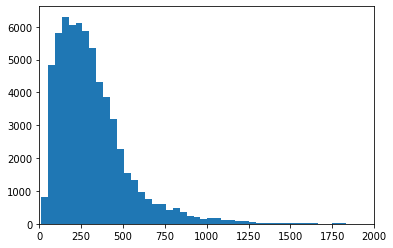

In [41]:
plt.hist(length_list,bins=200)
plt.xlim(0,2000)

In [42]:
thermo_df = df_combine[df_combine['class'] == 'Thermophillic']
thermo_seq_list = thermo_df['sequence'].tolist()
thermo_length_list = [len(i) for i in thermo_seq_list]

psychro_df = df_combine[df_combine['class'] == 'Psychrophillic']
psychro_seq_list = psychro_df['sequence'].tolist()
psychro_length_list = [len(i) for i in psychro_seq_list]

meso_df = df_combine[df_combine['class'] == 'Mesophillic']
meso_seq_list = meso_df['sequence'].tolist()
meso_length_list = [len(i) for i in meso_seq_list]

/software/conda/envs/tensorflow/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


(0, 2000)

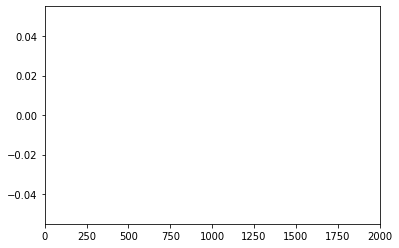

In [43]:
plt.hist(meso_length_list,bins=200)
plt.xlim(0,2000)

(0, 2000)

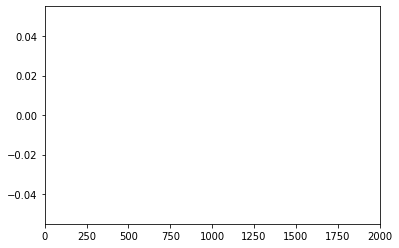

In [44]:
plt.hist(psychro_length_list,bins=200)
plt.xlim(0,2000)

(0, 2000)

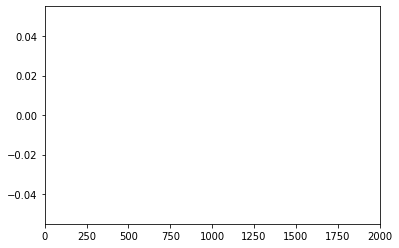

In [45]:
plt.hist(thermo_length_list,bins=200)
plt.xlim(0,2000)